# Example Ensembles: Australian Credit Card Assessment

In this example it will be compared 3 classifiers:
- Multilayer perceptron.
- Ensemble trained with Negative Correlation (Xin Yao, 1999).
- Ensemble trained with Correntropy.

## Data

This data base concerns credit card applications. All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data. This dataset is interesting because there is a good mix of attributes -- continuous, nominal with small numbers of values, and nominal with larger numbers of values. There are also a few missing values.
  
- Number of Instances: 690
- Number of Attributes: 14 + class attribute
- Attribute Information:   THERE ARE 6 NUMERICAL AND 8 CATEGORICAL ATTRIBUTES.
- Exist 2 classes and its distribution is:
    * +: 307 (44.5%)    CLASS 2
    * -: 383 (55.5%)    CLASS 1
- there are 6 numerical and 8 categorical attributes. the labels have been changed for the convenience of the statistical algorithms. For example, attribute 4 originally had 3 labels p,g,gg and these have been changed to labels 1,2,3.

- Missing Attribute Values: 37 cases (5%) HAD one or more missing values. The missing values from particular attributes WERE:
    * A1:  12
    * A2:  12
    * A4:   6
    * A5:   6
    * A6:   9
    * A7:   9
    * A14: 13
 
  These were replaced by the mode of the attribute (categorical) and mean of the attribute (continuous)


In [1]:
import theano
import theano.tensor as T
import numpy as np
from theano.sandbox import cuda

theano.config.floatX = 'float32'
cuda.use('gpu')
theano.config.compute_test_value = 'off'

path_data = r'data\australian.dat'
data = np.genfromtxt(path_data, delimiter=' ')

classes_names = np.asarray(['clase 1', 'clase 2'], dtype='<U10')
data_input    = np.asarray(data[:, 0:-1], dtype=theano.config.floatX)
data_target   = classes_names[np.asarray(data[:, -1:], dtype=int)]

Using gpu device 0: GeForce GT 630M (CNMeM is enabled with initial size: 75.0% of memory, CuDNN not available)


### Experimental Setup

The data set was partitioned into two sets: a training set and a testing set. The first 518 examples were used for the training set, and the remaining 172 examples for the testing set. The input attributes were rescaled to between 0.0 and 1.0 by a linear function. (**Ensemble learning via negative correlation, Y. Liua, X. Yao**)

In [2]:
from sklearn import preprocessing

data_input_norm = preprocessing.MinMaxScaler().fit_transform(data_input)

input_train = data_input_norm[0:517]
input_test = data_input_norm[518:690]
target_train = data_target[0:517]
target_test = data_target[518:690]

## Training MLP

This model has ten neurons in hidden layer and the output layer two neurons with **one hot encoding**. The cost function is MSE and update function is Stochastic gradient descendent. 

In [3]:
import time
from libml.models.sequential import Sequential
from libml.layers.dense import Dense
from libml.utils import *

mlp = Sequential(classes_names, "classifier", "mlp")
mlp.add_layer(Dense(n_input=data_input.shape[1], n_output=10, activation=T.nnet.sigmoid))
mlp.add_layer(Dense(n_output=len(classes_names), activation=T.nnet.sigmoid))
mlp.append_cost(mse)
mlp.set_update(sgd, learning_rate=0.1)
mlp.compile()

metrics_mlp = ClassifierMetrics(mlp)

max_epoch = 250
validation_jump = 5

for i in range(25):                      
    # training
    tic = time.time()
    metric = mlp.fit(input_train, target_train,
                                max_epoch=max_epoch, batch_size=32,
                                validation_jump=validation_jump, early_stop_th=4)
    toc = time.time()

    # Compute metrics
    metrics_mlp.append_prediction(target_test, mlp.predict(input_test))
    metrics_mlp.append_metric(metric)
    
    # Reset parameters
    mlp.reset()

    print("%d Elapsed time [s]: %f" % (i, toc - tic))

print("FINISHED MLP!")

0 Elapsed time [s]: 3.187331
1 Elapsed time [s]: 3.213213
2 Elapsed time [s]: 3.203308
3 Elapsed time [s]: 3.058862
4 Elapsed time [s]: 3.405392
5 Elapsed time [s]: 3.320222
6 Elapsed time [s]: 3.212139
7 Elapsed time [s]: 2.984817
8 Elapsed time [s]: 3.082823
9 Elapsed time [s]: 3.136387
10 Elapsed time [s]: 3.153313
11 Elapsed time [s]: 3.032718
12 Elapsed time [s]: 3.221459
13 Elapsed time [s]: 3.068503
14 Elapsed time [s]: 3.146107
15 Elapsed time [s]: 3.087476
16 Elapsed time [s]: 3.017451
17 Elapsed time [s]: 3.304460
18 Elapsed time [s]: 3.112807
19 Elapsed time [s]: 3.164552
20 Elapsed time [s]: 3.092505
21 Elapsed time [s]: 3.309749
22 Elapsed time [s]: 3.099591
23 Elapsed time [s]: 3.102640
24 Elapsed time [s]: 3.423244
FINISHED MLP!


## Results MLP

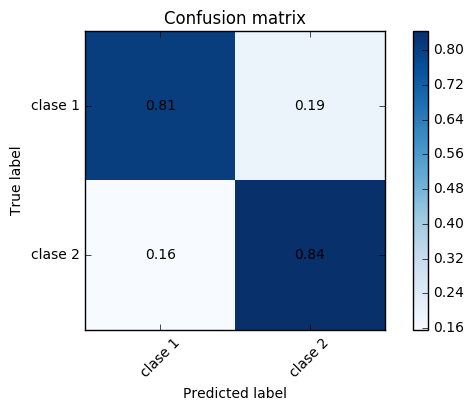

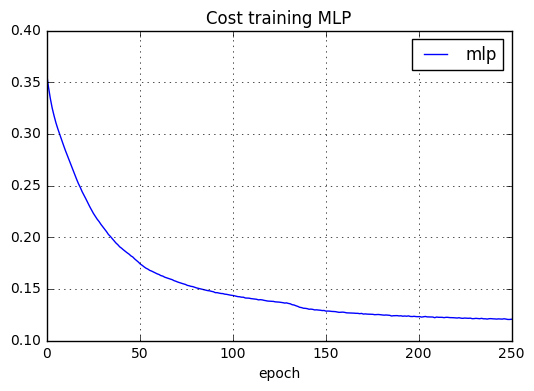

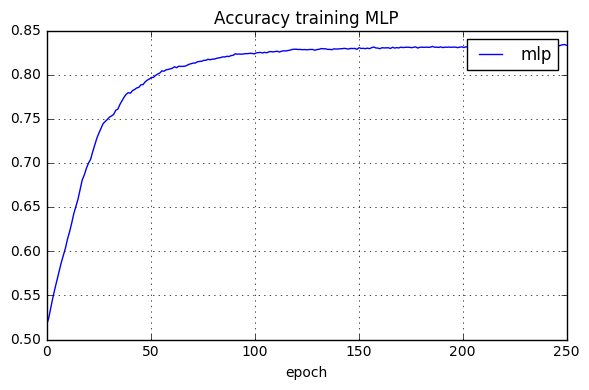

In [ ]:
%matplotlib inline
import matplotlib.pylab as plt

metrics_mlp.plot_confusion_matrix()
metrics_mlp.plot_cost(max_epoch, "Cost training MLP")
metrics_mlp.plot_score(max_epoch, "Accuracy training MLP")

plt.tight_layout()

## Training Ensemble - Negative Correlation (Xin Yao, 1999)

The ensemble architecture used in the experiments has four networks. Each individual network is a feedforward network with one hidden layer. Both the hidden node function and the output node function are defined by the logistic function. All the individual networks have ten hidden nodes. The number of training epochs was set to 250. The strength parameter of negative correlations was set to 1.0. These parameters were chosen after limited preliminary experiments. They are not meant to be optimal.

In [ ]:
from libml.ensemble.ensemblemodel import EnsembleModel

# Create Ensemble
ensemble_nc = EnsembleModel(name="Ensemble NC")

# Create models for ensemble
for i in range(4):
    net = Sequential(classes_names, "classifier", "net%d_ens_nc" % i)
    net.add_layer(Dense(n_input=data_input.shape[1], n_output=10, activation=T.nnet.sigmoid))
    net.add_layer(Dense(n_output=len(classes_names), activation=T.nnet.sigmoid))
    net.append_cost(mse)
    net.set_update(sgd, learning_rate=0.1)
    ensemble_nc.append_model(net)

ensemble_nc.add_cost_ensemble(fun_cost=neg_corr, lamb_neg_corr=1.0)  # adds neg correlation in all models
ensemble_nc.compile(fast=False)

metrics_ensemble = EnsembleClassifierMetrics(ensemble_nc)

for i in range(25):                      
    # training
    tic = time.time()
    metrics = ensemble_nc.fit(input_train, target_train,
                                max_epoch=max_epoch, batch_size=32,
                                validation_jump=validation_jump, early_stop_th=4)
    toc = time.time()

    # Compute metrics
    metrics_ensemble.append_prediction(target_test, ensemble_nc.predict(input_test))
    metrics_ensemble.append_metric(metrics)
    
    # Reset parameters of all ensemble's models
    ensemble_nc.reset()

    print("%d Elapsed time [s]: %f" % (i, toc - tic))

print("FINISHED!")

### Results Ensemble - Negative Correlation (same training set)

In [ ]:
%matplotlib inline
import matplotlib.pylab as plt

metrics_ensemble.plot_confusion_matrix()
metrics_ensemble.plot_cost(max_epoch, "Cost training Ensemble-NC")
metrics_ensemble.plot_cost_models(max_epoch, "Cost training Ensemble-NC per models")
metrics_ensemble.plot_score(max_epoch, "Accuracy training Ensemble-NC")
metrics_ensemble.plot_score_models(max_epoch, "Accuracy training Ensemble-NC per models")

plt.tight_layout()

## Training Ensemble - Correntropy

In [ ]:
from libml.ensemble.ensemblemodel import EnsembleModel

# Create Ensemble
ensemble_corrpy = EnsembleModel(name="Ensemble Correntropy")

# Create models for ensemble
for i in range(4):
    net = Sequential(classes_names, "classifier", "net%d_ens_corrpy" % i)
    net.add_layer(Dense(n_input=data_input.shape[1], n_output=10, activation=T.nnet.sigmoid))
    net.add_layer(Dense(n_output=len(classes_names), activation=T.nnet.sigmoid))
    net.append_cost(mse)
    net.set_update(sgd, learning_rate=0.1)
    ensemble_corrpy.append_model(net)

ensemble_corrpy.add_cost_ensemble(fun_cost=corrpy_cost, lamb_corr=1.0, s=2.5)  # adds correntropy cost in all models
ensemble_corrpy.compile(fast=False)

metrics_ensemble_corrpy = EnsembleClassifierMetrics(ensemble_nc)

for i in range(25):                      
    # training
    tic = time.time()
    metrics = ensemble_corrpy.fit(input_train, target_train,
                                max_epoch=max_epoch, batch_size=32,
                                validation_jump=validation_jump, early_stop_th=4)
    toc = time.time()

    # Compute metrics
    metrics_ensemble_corrpy.append_prediction(target_test, ensemble_corrpy.predict(input_test))
    metrics_ensemble_corrpy.append_metric(metrics)
    
    # Reset parameters of all ensemble's models
    ensemble_corrpy.reset()

    print("%d Elapsed time [s]: %f" % (i, toc - tic))

print("FINISHED!")

### Results Ensemble - Correntropy

In [ ]:
%matplotlib inline
import matplotlib.pylab as plt

metrics_ensemble_corrpy.plot_confusion_matrix()
metrics_ensemble_corrpy.plot_cost(max_epoch, "Cost training Ensemble-NC")
metrics_ensemble_corrpy.plot_cost_models(max_epoch, "Cost training Ensemble-NC per models")
metrics_ensemble_corrpy.plot_score(max_epoch, "Accuracy training Ensemble-NC")
metrics_ensemble_corrpy.plot_score_models(max_epoch, "Accuracy training Ensemble-NC per models")

plt.tight_layout